In [1]:
# Question 1 - Import data and Explore/Clean
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model, tree, neural_network
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

path = "D:\\Documents\\DAAN862\\Final\\"
os.chdir(path)

click_hist_fp = "click_history.csv"
prod_feat_fp = "product_features.csv"
user_feat_fp = "user_features.csv"

clicks = pd.read_csv(click_hist_fp)
prod = pd.read_csv(prod_feat_fp)
users = pd.read_csv(user_feat_fp)


In [2]:
# Let's look at clicks first to get an idea of the data.
display(clicks)
print('Unique Users: ', len(clicks['user_id'].unique()))

# No need to further explore, it is a list of each
# recorded user and whether they clicked on a product
# or not.

,user_id,product_id,clicked
0,104863,1350,False
1,108656,1321,True
2,100120,1110,False
3,104838,1443,True
4,107304,1397,True
...,...,...,...
35985,111177,1926,False
35986,111937,1699,True
35987,105921,1018,False
35988,106064,1082,True


Unique Users:  7200


In [3]:
# Let is make sure if any nulls exist in clicks
clicks.isnull().sum(axis=0)

# None were found in each column, so no need to edit this data

user_id       0
product_id    0
clicked       0
dtype: int64

In [4]:
# We will repeat the same behavior for product list
display(prod)
print('Unique Products: ', len(prod['product_id'].unique()))

print('Product ID Nulls:')
display(prod.isnull().sum(axis=0))

# Everything seems reasonable in this data set

,product_id,category,on_sale,number_of_reviews,avg_review_score
0,1134,tools,False,101,3.349452
1,1846,skincare,False,111,5.000000
2,1762,fragrance,False,220,4.882706
3,1254,hair,True,446,5.000000
4,1493,body,True,513,-1.000000
...,...,...,...,...,...
995,1541,fragrance,False,312,1.149903
996,1326,body,True,603,1.277216
997,1062,foot,True,705,3.602008
998,1721,makeup,True,306,1.846254


Unique Products:  1000
Product ID Nulls:


product_id           0
category             0
on_sale              0
number_of_reviews    0
avg_review_score     0
dtype: int64

In [5]:
# Repeat steps again for users
display(users)
print('Unique Users: ', len(users['user_id'].unique()))

print('Users Nulls:')
display(users.isnull().sum(axis=0))

# Unqiue users in this dataframe is more than the clicks df,
# We can assume that we can drop these for now since we can't
# relate them to a specific product, which will be done when we
# join the data sets
# There are 500 cases of 'number_of_clicks_before' being null though
# In this scenario, it is hard to assume what this means so
# we will just drop these rows.
users_bought = users.dropna()


,user_id,number_of_clicks_before,ordered_before,personal_interests
0,104939,2,True,"['body', 'makeup', 'nail', 'hand', 'foot', 'me..."
1,101562,2,True,"['men_skincare', 'men_fragrance', 'tools', 'sk..."
2,102343,2,True,"['tools', 'makeup', 'foot', 'nail']"
3,106728,5,True,"['hand', 'men_skincare']"
4,107179,0,True,"['makeup', 'body', 'skincare', 'foot', 'men_sk..."
...,...,...,...,...
11995,105121,6+,True,"['fragrance', 'hand', 'makeup', 'men_fragrance..."
11996,102607,1,False,"['body', 'makeup', 'tools', 'fragrance', 'nail..."
11997,106873,2,False,"['hair', 'tools', 'men_skincare', 'hand', 'bod..."
11998,107769,NaN,True,"['hand', 'men_skincare', 'tools', 'makeup', 'h..."


Unique Users:  12000
Users Nulls:


user_id                      0
number_of_clicks_before    500
ordered_before               0
personal_interests           0
dtype: int64

In [6]:
# Question 2 - Perform EDA and preprocess data

# We will start by merging all the data sets into a signle data frame since
# we know we can merge all users with their clicks, and then tie each click 
# to a specific product ID and the product's attributes. We may
# want to factor out further columns for models, and we have yet
# determined a method to handle personal interests.
users_merged_full = pd.merge(users_bought, clicks, on='user_id', how='inner')
users_prod_full = pd.merge(users_merged_full, prod, on='product_id', how='inner')
display(users_prod_full)

,user_id,number_of_clicks_before,ordered_before,personal_interests,product_id,clicked,category,on_sale,number_of_reviews,avg_review_score
0,104939,2,True,"['body', 'makeup', 'nail', 'hand', 'foot', 'me...",1212,False,hair,True,789,1.461363
1,101992,1,True,[],1212,False,hair,True,789,1.461363
2,110175,0,True,"['skincare', 'tools', 'foot', 'men_fragrance']",1212,True,hair,True,789,1.461363
3,111017,1,False,"['fragrance', 'skincare', 'foot', 'hand', 'hai...",1212,False,hair,True,789,1.461363
4,105516,6+,False,"['hair', 'tools', 'nail', 'fragrance', 'foot',...",1212,False,hair,True,789,1.461363
...,...,...,...,...,...,...,...,...,...,...
34420,107023,6+,True,"['tools', 'foot', 'men_skincare']",1481,True,men_skincare,True,354,5.000000
34421,109021,5,True,['fragrance'],1481,False,men_skincare,True,354,5.000000
34422,108315,2,True,"['men_skincare', 'hair', 'hand', 'nail', 'frag...",1481,True,men_skincare,True,354,5.000000
34423,106691,0,True,"['hair', 'tools', 'body', 'hand', 'makeup', 's...",1481,False,men_skincare,True,354,5.000000


In [7]:
# One method that may be reasonable is to create a new column that 
# contains a boolean value that relates to matches whether 
# each product was a match within the respective user's interest
# As in, if the prodct was for 'hair', and the user had an interest
# in 'hair' products, it would be True, where as it would be False
# if that user had no interests in 'hair'.

# Before we do that, let us make sure we don't need to clean/reword
# the interests between the two columns.
user_inter = []
for i in range(len(users_prod_full)):
    user_ints = users_prod_full['personal_interests'].iloc[i]
    prod_ints = users_prod_full['category'].iloc[i]
    if prod_ints in user_ints:
        user_inter.append(True)
    else:
        user_inter.append(False)

In [8]:
# Now we have a list of Trues and Falses, we can insert into
users_prod_full.insert(9, 'interest_matched', user_inter, True)

In [9]:
users_prod_full
# That looks correct

,user_id,number_of_clicks_before,ordered_before,personal_interests,product_id,clicked,category,on_sale,number_of_reviews,interest_matched,avg_review_score
0,104939,2,True,"['body', 'makeup', 'nail', 'hand', 'foot', 'me...",1212,False,hair,True,789,True,1.461363
1,101992,1,True,[],1212,False,hair,True,789,False,1.461363
2,110175,0,True,"['skincare', 'tools', 'foot', 'men_fragrance']",1212,True,hair,True,789,False,1.461363
3,111017,1,False,"['fragrance', 'skincare', 'foot', 'hand', 'hai...",1212,False,hair,True,789,True,1.461363
4,105516,6+,False,"['hair', 'tools', 'nail', 'fragrance', 'foot',...",1212,False,hair,True,789,True,1.461363
...,...,...,...,...,...,...,...,...,...,...,...
34420,107023,6+,True,"['tools', 'foot', 'men_skincare']",1481,True,men_skincare,True,354,True,5.000000
34421,109021,5,True,['fragrance'],1481,False,men_skincare,True,354,False,5.000000
34422,108315,2,True,"['men_skincare', 'hair', 'hand', 'nail', 'frag...",1481,True,men_skincare,True,354,True,5.000000
34423,106691,0,True,"['hair', 'tools', 'body', 'hand', 'makeup', 's...",1481,False,men_skincare,True,354,False,5.000000


In [10]:
# Now we will start by dropping irrelevant columns to begin the train_test split
X_full = users_prod_full.drop(columns=['clicked'])
X_full_clicks = X_full.replace({'number_of_clicks_before': '6+'}, {'number_of_clicks_before': 7})

In [11]:
X_full_clicks

,user_id,number_of_clicks_before,ordered_before,personal_interests,product_id,category,on_sale,number_of_reviews,interest_matched,avg_review_score
0,104939,2,True,"['body', 'makeup', 'nail', 'hand', 'foot', 'me...",1212,hair,True,789,True,1.461363
1,101992,1,True,[],1212,hair,True,789,False,1.461363
2,110175,0,True,"['skincare', 'tools', 'foot', 'men_fragrance']",1212,hair,True,789,False,1.461363
3,111017,1,False,"['fragrance', 'skincare', 'foot', 'hand', 'hai...",1212,hair,True,789,True,1.461363
4,105516,7,False,"['hair', 'tools', 'nail', 'fragrance', 'foot',...",1212,hair,True,789,True,1.461363
...,...,...,...,...,...,...,...,...,...,...
34420,107023,7,True,"['tools', 'foot', 'men_skincare']",1481,men_skincare,True,354,True,5.000000
34421,109021,5,True,['fragrance'],1481,men_skincare,True,354,False,5.000000
34422,108315,2,True,"['men_skincare', 'hair', 'hand', 'nail', 'frag...",1481,men_skincare,True,354,True,5.000000
34423,106691,0,True,"['hair', 'tools', 'body', 'hand', 'makeup', 's...",1481,men_skincare,True,354,False,5.000000


In [12]:
# Since we have boolean values, in order to better correspond with models,
# we can multiply all data by 1 to convert True and Falses to 1s and 0s
X_full_f = X_full_clicks*1

In [13]:
# Drop the strings
X_f = X_full_f.drop(columns=['personal_interests', 'category'])
X_f

,user_id,number_of_clicks_before,ordered_before,product_id,on_sale,number_of_reviews,interest_matched,avg_review_score
0,104939,2,1,1212,1,789,1,1.461363
1,101992,1,1,1212,1,789,0,1.461363
2,110175,0,1,1212,1,789,0,1.461363
3,111017,1,0,1212,1,789,1,1.461363
4,105516,7,0,1212,1,789,1,1.461363
...,...,...,...,...,...,...,...,...
34420,107023,7,1,1481,1,354,1,5.000000
34421,109021,5,1,1481,1,354,0,5.000000
34422,108315,2,1,1481,1,354,1,5.000000
34423,106691,0,1,1481,1,354,0,5.000000


In [14]:
# We can do the same for the y values, in this case,
# predicting whether the user clicked on a product or not
y = users_prod_full.clicked*1

In [15]:
y

0        0
1        0
2        1
3        0
4        0
        ..
34420    1
34421    0
34422    1
34423    0
34424    1
Name: clicked, Length: 34425, dtype: int32

In [16]:
# Split the data and begin models
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.3, random_state=123)

In [17]:
# One model we can use is a LogisticRegression Model:
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [18]:
# We can compare accuracy metrics as follows:
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

display(metrics.accuracy_score(y_train, lr_train_pred))
display(metrics.accuracy_score(y_test, lr_test_pred))

0.6443125700294643

0.6524012393493416

In [19]:
# Another option is Naive Bayes
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()

NB.fit(X_train, y_train)

NB_train_pred = NB.predict(X_train)
NB_test_pred = NB.predict(X_test)
print('Trained Accuracy:')
display(metrics.accuracy_score(y_train, NB_train_pred))
print('Test Accuracy:')
display(metrics.accuracy_score(y_test, NB_test_pred))

Trained Accuracy:


0.6443125700294643

Test Accuracy:


0.6524012393493416

In [20]:
# We can also use a Decision Tree
from sklearn import tree
DT = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 5)
DT.fit(X_train, y_train)

DT_pred = DT.predict(X_test)
print('Test Accuracy:')
display(metrics.accuracy_score(DT_pred, y_test))
print(metrics.classification_report(y_test, DT_pred))

Test Accuracy:


0.7406080557707204

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      6738
           1       0.63      0.60      0.62      3590

    accuracy                           0.74     10328
   macro avg       0.71      0.71      0.71     10328
weighted avg       0.74      0.74      0.74     10328



In [21]:
# And also Neural Network
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

NN = MLPClassifier(solver = 'lbfgs', alpha = 1e-5, 
                  hidden_layer_sizes = (10,4), random_state = 1)

NN.fit(X_train_scaled, y_train)

NN_pred = NN.predict(X_test_scaled)
print('Accuracy: ')
display(metrics.accuracy_score(NN_pred, y_test))
print(metrics.classification_report(y_test, NN_pred))

Accuracy: 


C:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.6554027885360186

              precision    recall  f1-score   support

           0       0.66      0.97      0.79      6738
           1       0.54      0.06      0.11      3590

    accuracy                           0.66     10328
   macro avg       0.60      0.52      0.45     10328
weighted avg       0.62      0.66      0.55     10328



array([0.09457571, 0.02361331, 0.05503412, 0.03128808, 0.0182031 ,
       0.70492278, 0.01617659, 0.05618631])

array([-5.58157132e-06, -1.50592285e-10, -1.92230634e-11, -7.77626887e-08,
       -1.76400611e-11, -9.36730887e-09, -1.94398782e-11, -1.61640958e-10])

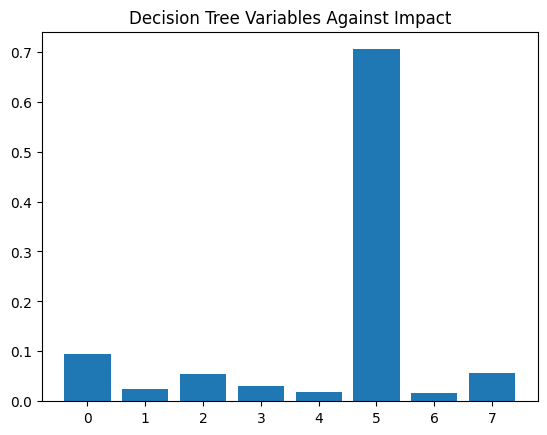

In [22]:
importance_lr = lr.coef_[0]
importance_dt = DT.feature_importances_

display(importance_dt)
display(importance_lr)

# Plot the DT Variables as Box plot
plt.bar([x for x in range(len(importance_dt))], importance_dt)
plt.title('Decision Tree Variables Against Impact')
plt.show()

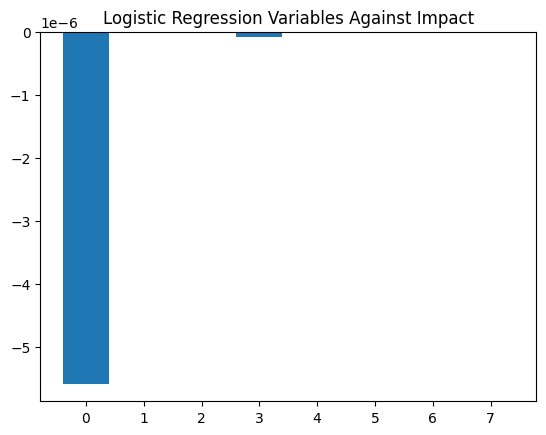

In [23]:
plt.bar([x for x in range(len(importance_lr))], importance_lr)
plt.title('Logistic Regression Variables Against Impact')
plt.show()

In [24]:
# Question 4 - Which Model is Best?

# Of all the models generated, it appears that a Decision Tree will 
# provide the most accurate results. The DT model returned a test accuracy
# of 0.74, which is about 10% higher than the other utilized models. 